In [4]:
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.insert(0, "..")
from stamp import *
from physics_dist414pc import *
from astropy.stats import sigma_clipped_stats
import re
import os
%load_ext autoreload
%autoreload 2

table_outflow = Table.read("../outflow_hops.csv", comment='#')
table_outflow_davis = Table.read("../outflow_davisnohops.csv", comment='#')
table_hops = Table.read("../../catalogs/hops.fits")
table_davis = Table.read("../../catalogs/davis09_jets_without_hops.txt", format='ascii.tab')
outflow_def = table_outflow[table_outflow['outflow'] == '1']
outflow_may = table_outflow[table_outflow['outflow'] == '?']
outflow_davis = table_outflow_davis[(table_outflow_davis['outflow'] == '1') | (table_outflow_davis['outflow'] == '?')]

c12 = SpectralCube.read("../../cubes/mask_imfit_12co_pix_2_Tmb.fits")
c13 = SpectralCube.read("../../cubes/mask_imfit_13co_pix_2_Tmb_regrid12co.fits")
c18 = SpectralCube.read("../../cubes/mask_imfit_c18o_pix_2_Tmb.fits")




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


7.528555538001431 km / s 13.720211831898501 km / s
1.0302046537399292 K 0.46668294072151184 K
75.253981660121 K
Davis 11
Fitted C18O cloud component(s) at 11.373983933309448 km / s
11.373983933309448 km / s
thick min:  3.0911433696746826 K thin min:  1.4005640745162964 K
ratio min:  -7069.89697265625
8563.923916788 m / s


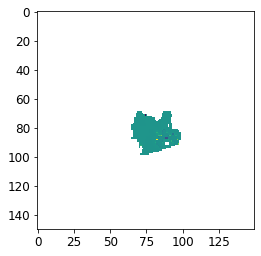

Guessing position angle of 31.181339868948193 deg
Blue PA: -35 deg deg, OA: 1.6e+02 deg deg
<SkyCoord (ICRS): (ra, dec) in deg
    (83.847083, -5.119444)>
Only one blue velocity inputted, integrating cube between the first channel at -1939.03276935 m / s and 7528.555538001431 m / s.
integrating SpectralCube with shape=(86, 150, 150) and unit=K:
 n_x:    150  type_x: RA---SIN  unit_x: deg    range:    83.805766 deg:   83.888882 deg
 n_y:    150  type_y: DEC--SIN  unit_y: deg    range:    -5.160792 deg:   -5.077999 deg
 n_s:     86  type_s: VOPT      unit_s: m / s  range:    -1939.033 m / s:   19316.951 m / s from -1939.03276935 m / s to 7528.555538001431 m / s
Only one red velocity inputted, integrating cube between 13720.211831898501 m / s and the last channel at 19316.951000215 m / s.
integrating SpectralCube with shape=(86, 150, 150) and unit=K:
 n_x:    150  type_x: RA---SIN  unit_x: deg    range:    83.805766 deg:   83.888882 deg
 n_y:    150  type_y: DEC--SIN  unit_y: deg    range

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [5]:
physics_table = Table( 
    names=["Source", "Lobe", "PA", "e_PA", "OA", "e_OA",
           "RAJ2000", "DEJ2000", "M_lowvel", "M_hivel", "P_lowvel",
           "P_hivel", "E_lowvel", "E_hivel",
           "vmax", "rmax", "tdyn",
           "Mdot_lowvel", "Mdot_hivel",
           "Pdot_lowvel", "Pdot_hivel",
           "Edot_lowvel", "Edot_hivel"], 
    dtype=["S10", "S10", "f8", "f8", "f8", "f8",
           "f8", "f8", "f8", "f8", "f8",
           "f8", "f8", "f8",
           "f8", "f8", "f8",
           "f8", "f8",
           "f8", "f8",
           "f8", "f8"]) 

physics_table["RAJ2000"].unit = u.deg
physics_table["DEJ2000"].unit = u.deg

physics_table["PA"].unit = u.deg
physics_table["e_PA"].unit = u.deg
physics_table["OA"].unit = u.deg
physics_table["e_OA"].unit = u.deg

physics_table["M_lowvel"].unit = u.Msun
physics_table["M_hivel"].unit = u.Msun
physics_table["P_lowvel"].unit = u.Msun/(u.km/u.s)
physics_table["P_hivel"].unit = u.Msun/(u.km/u.s)
physics_table["E_lowvel"].unit = u.erg
physics_table["E_hivel"].unit = u.erg

physics_table["vmax"].unit = u.km/u.s
physics_table["rmax"].unit = u.pc
physics_table["tdyn"].unit = u.yr

physics_table["Mdot_lowvel"].unit = u.Msun/u.yr
physics_table["Mdot_hivel"].unit = u.Msun/u.yr
physics_table["Pdot_lowvel"].unit = (u.Msun/(u.km/u.s))/u.yr
physics_table["Pdot_hivel"].unit = (u.Msun/(u.km/u.s))/u.yr
physics_table["Edot_lowvel"].unit = u.erg/u.s
physics_table["Edot_hivel"].unit = u.erg/u.s



for i, row in enumerate(outflow_davis):
    iwork = 0
    if i != iwork:
        continue
    davis = row["davis"]
    
#     hops = row["hops"]
    blue_vel, red_vel = row["blue_vel"], row["red_vel"]
    tanabe = row["tanabe"]
    note = row["notes"]
    davis_row = table_davis[table_davis["SMZ"] == davis][0]
#     hops_row = table_hops[table_hops["HOPS"] == hops][0]
#     coord = SkyCoord(hops_row["RAJ2000"], hops_row["DEJ2000"], unit=u.deg)
    coord = SkyCoord(davis_row["_RAJ2000"], davis_row["_DEJ2000"], unit=u.deg)
    
    plot_dir = "davis{}_plots/".format(davis)
    os.makedirs(plot_dir, exist_ok=True)
    
    # Read in the hand-drawn masks for the blue/red lobes.    
    width = height = u.Quantity(glob.glob("../masks/maskroi_davis{}*.npy".format(davis))[0].split('_')[2])
    try:
        mask_blue = np.load(glob.glob("../masks/maskroi_davis{}_*blue.npy".format(davis))[0])
        no_blue = False
    except IndexError:
        no_blue = True
        mask_blue = False
    try:       
        mask_red = np.load(glob.glob("../masks/maskroi_davis{}_*red.npy".format(davis))[0])
        no_red = False
    except IndexError:
        no_red = True
        mask_red = False
    try:
        mask_full = np.load(glob.glob("../masks/maskroi_davis{}_*arcmin.npy".format(davis))[0])
    except IndexError:
        mask_full = mask_blue + mask_red

    sub12 = extract_subcube(c12, region_class=RectangleSkyRegion,
                      region_kwargs=dict(center=coord, width=width, height=height))
    sub13 = extract_subcube(c13, region_class=RectangleSkyRegion,
                        region_kwargs=dict(center=coord, width=width, height=height))
    
    #PARSE BLUE/RED_VEL FROM TABLE
    #     print(blue_vel, red_vel)
    if blue_vel == '-':
        fit_12 = extract_subcube(sub12, CircleSkyRegion,
                                region_kwargs={'center':coord, 'radius':15*u.arcsec})

        blue_vel, red_vel = calc_linewings(fit_12, nsigma_vel=2.)
        blue_vel, red_vel = blue_vel.to(u.km/u.s), red_vel.to(u.km/u.s)
    #         print(blue_vel, red_vel)
    else:
        try:
            blue_vel, red_vel = float(blue_vel)*u.km/u.s, float(red_vel)*u.km/u.s
        except ValueError:
            blue_vel, red_vel = blue_vel.strip("[]").split(','), red_vel.strip("[]").split(',')
            blue_vel = [float(a) for a in blue_vel]*u.km/u.s
            red_vel = [float(a) for a in red_vel]*u.km/u.s

    print(blue_vel, red_vel)
    
    #Calculate RMS in emission-free channels. Only consider pixels outside outflow mask.
    rms12 = rms(sub12.with_mask(~mask_full), velocity_range=[[-2,0],[18,20]]*u.km/u.s,
               sigma_clipped=True)
    rms13 = rms(sub13.with_mask(~mask_full), velocity_range=[[0,2], [16,18]]*u.km/u.s,
               sigma_clipped=True)
    print(rms12, rms13)
    
    
    #Use only the pixels with a integrated intensities > SNR set below in the 
    #visually defined velocity ranges.
    outflow_mom0_snr = 5.
    
    try:
        slab_blue = sub12.spectral_slab(sub12.spectral_extrema[0], blue_vel)
    except:
        slab_blue = sub12.spectral_slab(blue_vel[0], blue_vel[1])
    try:
        slab_red = sub12.spectral_slab(red_vel, sub12.spectral_extrema[1])
    except:
        slab_red = sub12.spectral_slab(red_vel[0], red_vel[1])
    
    mask_bluelobe = mask_blue & (slab_blue.moment0() > outflow_mom0_snr*sigma_mom0(slab_blue, channel_sigma=rms12))
    mask_redlobe = mask_red & (slab_red.moment0() > outflow_mom0_snr*sigma_mom0(slab_red, channel_sigma=rms12))
    mask_outflow = mask_bluelobe + mask_redlobe
    
    mask12_3sig = sub12 > 3*rms12
    mask13_3sig = sub13 > 3*rms13
    mask12_5sig = sub12 > 5*rms12
    mask13_5sig = sub13 > 5*rms13
      
    
    #Calculate Tex using the peak temperature of the average 12co spectrum.
    Tex_peak = cube_Tex(sub12.with_mask(mask_outflow), thick=True, plot="tex.png", average=True, average_first=True)
    plt.savefig(plot_dir + "Tex.pdf")
#     plt.show()
    plt.clf()
    print(Tex_peak)
    print("Davis", davis)
    
    #Fit the C18O spectrum with 1 or more gaussians to get the mean velocity of the cloud, or cloud components
    #along the line of sight.
    c18o_radius = 15*u.arcsec
    sub18 = extract_subcube(c18, region_class=CircleSkyRegion,
                                        region_kwargs=dict(center=coord, radius=c18o_radius))

    spec18_mean = extract_spectrum(sub18, spectral_unit=u.km/u.s)

    spec18_gauss = fit_gaussian(spec18_mean.spectral_axis, spec18_mean, n_models=1, autoguess=True)
    try:
        vsys = np.sort([g.mean.value for g in spec18_gauss])*spec18_mean.spectral_axis.unit
    except TypeError:
        vsys = spec18_gauss.mean.value*spec18_mean.spectral_axis.unit
        
    plt.plot(spec18_mean.spectral_axis, spec18_mean)
    plt.plot(spec18_mean.spectral_axis, spec18_gauss(spec18_mean.spectral_axis))
    plt.savefig(plot_dir + "c18o_fit.pdf")
#     plt.show()
    plt.clf()
    print("Fitted C18O cloud component(s) at", vsys)
    
    #Compute the velocity-dependent opacity correction. This could be fitting either a quadratic, or a 4-th order polynomial
    #if there are two distinct cloud components.
    fit_range = [vsys.value-1,vsys.value+1]*u.km/u.s
    print(vsys)
    sub12_correct, correctfactor = opacity_correct(sub12.with_mask(mask_outflow).with_mask(mask12_3sig), 
                                              sub13.with_mask(mask_outflow).with_mask(mask13_3sig),
                                              weighted_fit=False, fixed_fit=False,
                                              snr_cutoff=0, fit_func="parabola", vsys=vsys, fit_range=fit_range,    
                                              plot_ratio=True,
                                              errorbar_kwargs=dict(markersize=5, marker='s', ls='', lw=1, zorder=0),           
                                              plot_kwargs=dict(c='tab:orange'),
                                              return_factor=True)
    plt.savefig(plot_dir + "opacity_correct.pdf")
    #     plt.show()
    plt.clf()
    #Compute the mass spectrum in the outflow region
    #and integrate starting 1 km/s away from the peak(s) to get the total mass of the outflow.
    #the mass spectrum and masscube both have units of Msun / (km/s)
    dmdv_correct, masscube_correct = dmdv(sub12_correct, molecule='12co', Tex=Tex_peak,
                                         return_cube=True)
        
    
    #Fit the mass spectrum with n gaussians and subtract off the cloud spectrum.
    n = 1
    # print(dmdv_correct.spectral_axis)
    dv = 1*u.km/u.s
    
    
    #Calculate mass specturm and ambient cloud correction for each lobe individually. Then integrate
    #the mass spectrum at high velocities and add to the ambient-subtracted mass at low velocities.
    
    
    ### Compute Rmax and Vmax of lobes.
    if not no_blue:
        vmax_blue, _ = vmax_cube(sub12.with_mask(mask_bluelobe).with_mask(mask12_3sig), vsys=vsys, min_pixels=1, plot=True)
        rmax_blue = rmax_cube(sub12.with_mask(mask_bluelobe), coord_zero=coord, dist=dist)
        tdyn_blue = (rmax_blue / vmax_blue).to(u.yr)
    if not no_red:
        _, vmax_red = vmax_cube(sub12.with_mask(mask_redlobe).with_mask(mask12_3sig), vsys=vsys, min_pixels=1, plot=True)
        rmax_red = rmax_cube(sub12.with_mask(mask_redlobe), coord_zero=coord, dist=dist)
        tdyn_red = (rmax_red / vmax_red).to(u.yr)
    plt.savefig(plot_dir + "vmax.pdf")
#     plt.show()
    plt.clf()
    ### Compute outflow angles of lobes.  
    if not no_blue:
        blue_pa, blue_oa, e_blue_pa, e_blue_oa = outflow_angles(sub12.with_mask(mask_bluelobe), autoguess=True,
                   plot=True, plothist_kwargs=dict(facecolor='tab:blue', alpha=0.8),
                   bins=30, return_error=True)
        print("Blue PA: {:.2g} deg, OA: {:.2g} deg".format(blue_pa, blue_oa))
    plt.savefig(plot_dir + "pa_blue.pdf")
#     plt.show()
    plt.clf()

    if not no_red:
        red_pa, red_oa, e_red_pa, e_red_oa = outflow_angles(sub12.with_mask(mask_redlobe), autoguess=True,
                   plot=True, plothist_kwargs=dict(facecolor='tab:red', alpha=0.8),
                   bins=30, return_error=True)
        print("Red PA: {:.2g} deg, OA: {:.2g} deg".format(red_pa, red_oa))
    plt.savefig("pa_red.pdf")
#     plt.show()
    plt.clf()
    
    if not no_blue:
        
        dmdv_correct_blue, masscube_correct_blue = dmdv(sub12_correct.with_mask(mask_bluelobe), molecule='12co',
                                                       Tex=Tex_peak, return_cube=True)
        dmdv_outflow_blue, dmdv_fit_blue = ambient_correct(dmdv_correct_blue, n_models=n, plot=False,
                                   autoguess=True, return_fit=True)
        
        M_blue_lowvel = sum_dmdv(dmdv_outflow_blue, vrange=[blue_vel.value, (vsys-dv).value]*u.km/u.s,
                                    return_lobes=False, vsys=vsys)
        M_blue_hivel = sum_dmdv(dmdv_correct_blue, vrange=[-2, blue_vel.value]*u.km/u.s,
                               return_lobes=False, vsys=vsys)
        Mdot_blue_lowvel = (M_blue_lowvel / tdyn_blue).to(u.Msun/u.yr)
        Mdot_blue_hivel = (M_blue_hivel / tdyn_blue).to(u.Msun/u.yr)
        
        P_blue_lowvel = momentum_dmdv(dmdv_outflow_blue, vrange=[blue_vel.value, (vsys-dv).value]*u.km/u.s,
                                     return_lobes=False, vsys=vsys)
        P_blue_hivel = momentum_dmdv(dmdv_correct_blue, vrange=[-2, blue_vel.value]*u.km/u.s,
                               return_lobes=False, vsys=vsys)
        Pdot_blue_lowvel = (P_blue_lowvel / tdyn_blue).to(u.Msun * u.km / (u.s * u.yr))
        Pdot_blue_hivel = (P_blue_hivel / tdyn_blue).to(u.Msun * u.km / (u.s * u.yr))
        
        E_blue_lowvel = energy_dmdv(dmdv_outflow_blue, vrange=[blue_vel.value, (vsys-dv).value]*u.km/u.s,
                                     return_lobes=False, vsys=vsys)
        E_blue_hivel = energy_dmdv(dmdv_correct_blue, vrange=[-2, blue_vel.value]*u.km/u.s,
                               return_lobes=False, vsys=vsys)
        Edot_blue_lowvel = (E_blue_lowvel / tdyn_blue).to(u.erg/u.s)
        Edot_blue_hivel = (E_blue_hivel / tdyn_blue).to(u.erg/u.s)
        
        i_blue = dmdv_correct_blue.spectral_axis < vsys
        i_highvel = dmdv_correct_blue.spectral_axis <= blue_vel
        i_lowvel = (dmdv_correct_blue.spectral_axis >= blue_vel) & (dmdv_correct_blue.spectral_axis <= (vsys - 1*u.km/u.s))
# #         print("vsys ", vsys)
# #         print(i_highvel, i_lowvel)
#         print(M_blue_lowvel, M_blue_hivel)
        
        plt.plot(dmdv_correct_blue.spectral_axis[i_blue], dmdv_correct_blue[i_blue], color='tab:blue')
#         plt.plot(dmdv_outflow_blue.spectral_axis[i_blue], dmdv_outflow_blue[i_blue], ls=':', color='tab:blue')
        plt.plot(dmdv_correct_blue.spectral_axis[i_lowvel], dmdv_fit_blue(dmdv_correct_blue.spectral_axis[i_lowvel]),
                color='black')
        plt.fill_between(dmdv_correct_blue.spectral_axis[i_highvel], dmdv_correct_blue[i_highvel],
                        color='tab:blue')
        plt.fill_between(dmdv_correct_blue.spectral_axis[i_lowvel], dmdv_correct_blue[i_lowvel],
                dmdv_fit_blue(dmdv_correct_blue.spectral_axis[i_lowvel]),
                facecolor='tab:blue', alpha=0.4)
        
#         plt.fill_between(dmdv_outflow_blue.spectral_axis[i_lowvel], dmdv_outflow_blue[i_lowvel],
#                         facecolor='none', edgecolor='tab:blue', hatch='/')
    if not no_red:
        dmdv_correct_red, masscube_correct_red = dmdv(sub12_correct.with_mask(mask_redlobe), molecule='12co',
                                                      Tex=Tex_peak, return_cube=True)
        dmdv_outflow_red, dmdv_fit_red = ambient_correct(dmdv_correct_red, n_models=n, plot=False,
                                   autoguess=True,
                                   gaussian_kwargs=dict(amplitude=9*u.Msun/(u.km/u.s), mean=11*u.km/u.s, stddev=1*u.km/u.s),
                                   return_fit=True, fit_func=fitting.SLSQPLSQFitter())
        
        M_red_lowvel = sum_dmdv(dmdv_outflow_red, vrange=[(vsys+dv).value, red_vel.value]*u.km/u.s,
                                    return_lobes=False, vsys=vsys)
        M_red_hivel = sum_dmdv(dmdv_correct_red, vrange=[red_vel.value, 20.]*u.km/u.s,
                                    return_lobes=False, vsys=vsys)
        Mdot_red_lowvel = (M_red_lowvel / tdyn_red).to(u.Msun/u.yr)
        Mdot_red_hivel = (M_red_hivel / tdyn_red).to(u.Msun/u.yr)
        print(M_red_lowvel, M_red_hivel)
        
        P_red_lowvel = momentum_dmdv(dmdv_outflow_red, vrange=[(vsys+dv).value, red_vel.value]*u.km/u.s,
                                    return_lobes=False, vsys=vsys)
        P_red_hivel = momentum_dmdv(dmdv_correct_red, vrange=[red_vel.value, 20.]*u.km/u.s,
                                    return_lobes=False, vsys=vsys)
        Pdot_red_lowvel = (P_red_lowvel / tdyn_red).to(u.Msun * u.km / (u.s * u.yr))
        Pdot_red_hivel = (P_red_hivel / tdyn_red).to(u.Msun * u.km / (u.s * u.yr))
        
        E_red_lowvel = energy_dmdv(dmdv_outflow_red, vrange=[(vsys+dv).value, red_vel.value]*u.km/u.s,
                                    return_lobes=False, vsys=vsys)
        E_red_hivel = energy_dmdv(dmdv_correct_red, vrange=[red_vel.value, 20.]*u.km/u.s,
                                    return_lobes=False, vsys=vsys)
        Edot_red_lowvel = (E_red_lowvel / tdyn_red).to(u.erg/u.s)
        Edot_red_hivel = (E_red_hivel / tdyn_red).to(u.erg/u.s)
#         print("red_vel", red_vel) 
        i_red = dmdv_correct_red.spectral_axis > vsys
        i_highvel = dmdv_correct_red.spectral_axis >= red_vel
        i_lowvel = (dmdv_correct_red.spectral_axis < red_vel) & (dmdv_correct_red.spectral_axis > (vsys + 1*u.km/u.s))
        print(i_highvel, i_lowvel)
        plt.plot(dmdv_correct_red.spectral_axis[i_red], dmdv_correct_red[i_red], color='tab:red')
#         plt.plot(dmdv_correct_red.spectral_axis, dmdv_correct_red, color='tab:red')
#         plt.plot(dmdv_outflow_red.spectral_axis[i_red], dmdv_outflow_red[i_red], ls=':', color='tab:red')
        plt.plot(dmdv_correct_red.spectral_axis[i_lowvel], dmdv_fit_red(dmdv_correct_red.spectral_axis[i_lowvel]),
                color='black')
#         plt.plot(dmdv_correct_red.spectral_axis, dmdv_fit_red(dmdv_correct_red.spectral_axis),
#                 color='black')
        plt.fill_between(dmdv_correct_red.spectral_axis[i_highvel], dmdv_correct_red[i_highvel],
                        color='tab:red')
        plt.fill_between(dmdv_correct_red.spectral_axis[i_lowvel], dmdv_correct_red[i_lowvel],
                        dmdv_fit_red(dmdv_correct_red.spectral_axis[i_lowvel]),
                        facecolor='tab:red', alpha=0.4)
#         plt.fill_between(dmdv_outflow_red.spectral_axis[i_lowvel], dmdv_outflow_red[i_lowvel],
#                         facecolor='none', edgecolor='tab:red', hatch='/')
        

        
        
    print(coord)
    plt.semilogy()
#     plt.xlim(-2, 20)
    plt.ylim(1e-4, 10)
    
    plt.savefig(plot_dir + "dmdv.pdf")
#     plt.show()
    plt.clf()
    
    fig = plt.figure(figsize=(10,5))
    plot_finder(sub12, coord=coord,
            fit_cube=sub12, fig=fig,
            blue_vel=blue_vel.to(u.m/u.s), red_vel=red_vel.to(u.m/u.s),
            channel_sigma=rms12, fit_spectrum=False, show_vrange=False, show_fit=False,
            region_width=width, region_height=height,
            blue_levels=np.arange(5, 55, 5), red_levels=np.arange(5, 55, 5),
            show_spectrum=False,
            catalogs=["/Users/jesse/repos/outflows/catalogs/hops.fits",
                      "/Users/jesse/repos/outflows/catalogs/davis09_h2jets.fits",
                      "/Users/jesse/repos/outflows/catalogs/spitzer_orion.fit"],
            catalog_kwargs=[dict(marker="s", s=10, color='black', lw=1, zorder=3),
                        dict(marker="+", s=60, color='black', lw=1, zorder=3),
                        dict(marker=".", s=5, color='black', lw=1, zorder=3)])
    ax = fig.axes[0]
    wcs = sub12.wcs.celestial
    x,y = wcs.all_world2pix(coord.ra, coord.dec, -1)
#     print(xy)
#     xy = coord.ra
    pix_pc = dist * sub12.header['CDELT2']*3600. / (206265)
    print(rmax_blue, pix_pc)
    if not no_blue:
        w_blue = matplotlib.patches.Wedge(
            (x,y), (rmax_blue/pix_pc).value,
            (blue_pa-blue_oa/2).value+90, (blue_pa+blue_oa/2).value+90,
            alpha=0.2, facecolor='blue')
        ax.add_patch(w_blue)
        
    if not no_red:
        w_red = matplotlib.patches.Wedge(
            (x,y), (rmax_red/pix_pc).value,
            (red_pa-red_oa/2).value+90, (red_pa+red_oa/2).value+90,
            alpha=0.2, facecolor='red')
        ax.add_patch(w_red)
    plt.savefig(plot_dir + "stamp.pdf")
    plt.clf()
    if not no_blue:
        table_row = dict(Source = "SMZ {}".format(davis), Lobe = "B", PA = blue_pa.to(u.deg), e_PA = e_blue_pa.to(u.deg),
                        OA = blue_oa.to(u.deg), e_OA = e_blue_oa.to(u.deg),
                        RAJ2000 = coord.ra.to(u.deg), DEJ2000 = coord.dec.to(u.deg),
                        M_lowvel = M_blue_lowvel.to(u.Msun), M_hivel = M_blue_hivel.to(u.Msun),
                        P_lowvel = P_blue_lowvel.to(u.Msun*u.km/u.s), P_hivel = P_blue_hivel.to(u.Msun*u.km/u.s),
                        E_lowvel = E_blue_lowvel.to(u.erg), E_hivel = E_blue_hivel.to(u.erg),
                        vmax = vmax_blue.to(u.km/u.s), rmax = rmax_blue.to(u.pc), tdyn = tdyn_blue.to(u.yr),
                        Mdot_lowvel = Mdot_blue_lowvel.to(u.Msun/u.yr),
                        Mdot_hivel = Mdot_blue_hivel.to(u.Msun/u.yr),
                        Pdot_lowvel = Pdot_blue_lowvel.to(u.Msun*u.km/u.s/u.yr),
                        Pdot_hivel = Pdot_blue_hivel.to(u.Msun*u.km/u.s/u.yr),
                        Edot_lowvel = Edot_blue_lowvel.to(u.erg/u.s), 
                        Edot_hivel = Edot_blue_hivel.to(u.erg/u.s))
        
        physics_table.add_row(table_row)
        
    if not no_red:
        table_row = dict(Source = "SMZ {}".format(davis), Lobe = "R", PA = red_pa.to(u.deg), e_PA = e_red_pa.to(u.deg),
                        OA = red_oa.to(u.deg), e_OA = e_red_oa.to(u.deg),
                        RAJ2000 = coord.ra.to(u.deg), DEJ2000 = coord.dec.to(u.deg),
                        M_lowvel = M_red_lowvel, M_hivel = M_red_hivel,
                        P_lowvel = P_red_lowvel.to(u.Msun*u.km/u.s), P_hivel = P_red_hivel.to(u.Msun*u.km/u.s),
                        E_lowvel = E_red_lowvel.to(u.erg), E_hivel = E_red_hivel.to(u.erg),
                        vmax = vmax_red.to(u.km/u.s), rmax = rmax_red.to(u.pc), tdyn = tdyn_red.to(u.yr),
                        Mdot_lowvel = Mdot_red_lowvel.to(u.Msun/u.yr),
                        Mdot_hivel = Mdot_red_hivel.to(u.Msun/u.yr),
                        Pdot_lowvel = Pdot_red_lowvel.to(u.Msun*u.km/u.s/u.yr),
                        Pdot_hivel = Pdot_red_hivel.to(u.Msun*u.km/u.s/u.yr),
                        Edot_lowvel = Edot_red_lowvel.to(u.erg/u.s), 
                        Edot_hivel = Edot_red_hivel.to(u.erg/u.s))
        physics_table.add_row(table_row)
        plt.clf()
print(physics_table)   
physics_table.write("physics_table.txt", format='ascii')

# physics_table = Table( 
#     names=["Source", "Lobe", "PA", "OA",
#            "RAJ2000", "DEJ2000", "M_lowvel", "M_hivel", "P_lowvel",
#            "P_hivel", "E_lowvel", "E_hivel",
#            "vmax", "rmax", "tdyn",
#            "Mdot_lowvel", "Mdot_hivel",
#            "Pdot_lowvel", "Pdot_hivel",
#            "Edot_lowvel", "Edot_hivel"], 
#     dtype=["str", "str", "f8", "f8",
#            "f8", "f8", "f8", "f8", "f8", "f8", "f8", "f8",
#            "f8", "f8", "f8", "f8", "f8", "f8", "f8", "f8", "f8"]) 


In [6]:
physics_table

Source,Lobe,PA,e_PA,OA,e_OA,RAJ2000,DEJ2000,M_lowvel,M_hivel,P_lowvel,P_hivel,E_lowvel,E_hivel,vmax,rmax,tdyn,Mdot_lowvel,Mdot_hivel,Pdot_lowvel,Pdot_hivel,Edot_lowvel,Edot_hivel
,,deg,deg,deg,deg,deg,deg,solMass,solMass,s solMass / km,s solMass / km,erg,erg,km / s,pc,yr,solMass / yr,solMass / yr,s solMass / (km yr),s solMass / (km yr),erg / s,erg / s
bytes10,bytes10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
SMZ 11,B,-34.91190152401456,2.581183029366607,156.9953609601039,8.828688862455142,83.847083,-5.119444,1.4437135819893574,0.1278386407604257,3.5936680459064476,0.5924654904114701,9.398856375815229e+43,2.7926531438767966e+43,7.061256770434448,0.11108322034904408,15382.008096699592,9.385728917273973e-05,8.310920131933562e-06,0.00023362801679174225,3.851678445927949e-05,1.93623475111928e+32,5.753074468624123e+31


Guessing position angle of 31.181339868948193 deg
2.581183029366607 deg 8.828688862455142 deg


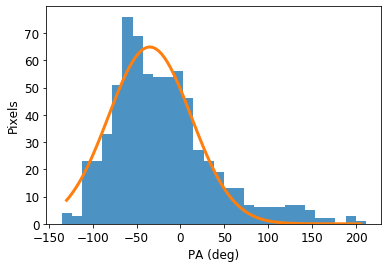

In [4]:
blue_pa, blue_oa, e_blue_pa, e_blue_oa= outflow_angles(sub12.with_mask(mask_bluelobe), autoguess=True,
           plot=True, plothist_kwargs=dict(facecolor='tab:blue', alpha=0.8),
           bins=30, return_error=True)
print(e_blue_pa, e_blue_oa)
    

thick min:  3.0911433696746826 K thin min:  1.4005640745162964 K
ratio min:  -7069.89697265625
8563.923916788 m / s


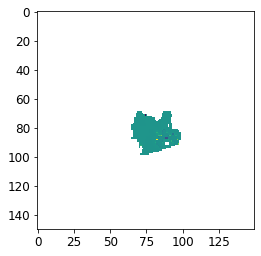

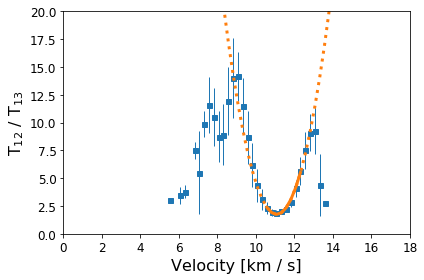

In [5]:
    sub12_correct, correctfactor = opacity_correct(sub12.with_mask(mask_outflow).with_mask(mask12_3sig),
                                              sub13.with_mask(mask_outflow).with_mask(mask13_3sig),
                                              weighted_fit=False, fixed_fit=False,
                                              snr_cutoff=0, fit_func="parabola", vsys=vsys, fit_range=fit_range,    
                                              plot_ratio=True,
                                              errorbar_kwargs=dict(markersize=5, marker='s', ls='', lw=1, zorder=0),           
                                              plot_kwargs=dict(c='tab:orange'),
                                              return_factor=True)
    plt.show()
    

In [6]:
physics_table['PA'].unit = u.deg

physics_table

Source,Lobe,PA,e_PA,OA,e_OA,RAJ2000,DEJ2000,M_lowvel,M_hivel,P_lowvel,P_hivel,E_lowvel,E_hivel,vmax,rmax,tdyn,Mdot_lowvel,Mdot_hivel,Pdot_lowvel,Pdot_hivel,Edot_lowvel,Edot_hivel
,,deg,deg,deg,deg,deg,deg,solMass / yr,solMass / yr,s solMass / (km yr),s solMass / (km yr),erg / s,erg / s,km / s,pc,yr,,,,,,
bytes10,bytes10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
SMZ 11,B,-34.91190152401456,2.581183029366607,156.9953609601039,8.828688862455142,83.847083,-5.119444,1.4437135819893574,0.1278386407604257,3.5936680459064476,0.5924654904114701,9.398856375815229e+43,2.7926531438767966e+43,7.061256770434448,0.11108322034904408,15382.008096699592,9.385728917273973e-05,8.310920131933562e-06,0.00023362801679174225,3.851678445927949e-05,1.93623475111928e+32,5.753074468624123e+31
